# Project 2: NYC Restaurant Inspections vs. Complaints
This project explores the relationship between restaurant inspections per month and complaints, particularly about food establishments. 
311 dataset: https://data.cityofnewyork.us/d/erm2-nwe9
Inspections dataset: https://data.cityofnewyork.us/d/43nn-pn8j

In [28]:
import pandas as pd

inspections_url = "https://data.cityofnewyork.us/resource/43nn-pn8j.csv?$select=camis,boro,inspection_date&$where=inspection_date%20>=%20'2019-01-01'&$limit=300000"

df_inspections = pd.read_csv(inspections_url, parse_dates=["inspection_date"])
df_inspections.head()


,camis,boro,inspection_date
0,50075461,Manhattan,2024-04-30
1,41668282,Manhattan,2025-07-17
2,50066463,Manhattan,2022-04-18
3,50129114,Queens,2023-08-11
4,50049514,Queens,2021-09-03


First, I used an API call to access the restaurant inspection data, with only necessary columns. I asked ChatGPT (I was having trouble figuring out selecting the columns we needed) to help me figure out how to filter for only the three columns I needed: unique code, Boro (just in case, although ultimately I decided to aggregate citywide), and Inspection Date. I also filtered to only inspections on 1/1/2024 or later, and will do the same for the 311 dataset. 

In [ ]:
complaints_url = "https://data.cityofnewyork.us/resource/erm2-nwe9.csv?$select=created_date,complaint_type,descriptor,location_type,borough&$where=(complaint_type='Rodent'%20OR%20upper(descriptor)%20like%20'%25RODENT%25')%20AND%20upper(location_type)%20like%20'%25RESTAURANT%25'%20AND%20created_date>='2019-01-01T00:00:00'&$limit=50000"

df_complaints = pd.read_csv(complaints_url, parse_dates=["created_date"])
df_complaints.head()

,created_date,complaint_type,descriptor,location_type,borough
0,2025-11-23 22:50:49,Food Establishment,Rodents/Insects/Garbage,Restaurant/Bar/Deli/Bakery,MANHATTAN
1,2025-11-23 21:50:19,Food Establishment,Rodents/Insects/Garbage,Restaurant/Bar/Deli/Bakery,MANHATTAN
2,2025-11-23 21:31:24,Food Establishment,Rodents/Insects/Garbage,Restaurant/Bar/Deli/Bakery,MANHATTAN
3,2025-11-23 20:58:37,Food Establishment,Rodents/Insects/Garbage,Restaurant/Bar/Deli/Bakery,BROOKLYN
4,2025-11-23 20:23:56,Food Establishment,Rodents/Insects/Garbage,Restaurant/Bar/Deli/Bakery,QUEENS


I accessed the 311 dataset, again asking ChatGPT to help me filter for the relevant Complaint Type (Rodent) and location type (Restaurant/Bar/Deli/Bakery), as well as the date and borough. I used the data dictionary for the dataset to find the relevant complaint type, descriptors, and location type. 
For both datasets, I used parse_dates to turn the dates into proper date formats to then easily aggregate them. 

In [ ]:
df_inspections["inspection_date"] = pd.to_datetime(
    df_inspections["inspection_date"], format="%m/%d/%Y"
)
df_complaints["created_date"] = pd.to_datetime(
    df_complaints["created_date"], format="%m/%d/%Y"
)
df_complaints.head()


,created_date,complaint_type,descriptor,location_type,borough,Date
0,2025-11-23 22:50:49,Food Establishment,Rodents/Insects/Garbage,Restaurant/Bar/Deli/Bakery,MANHATTAN,2025-11-23 22:50:49
1,2025-11-23 21:50:19,Food Establishment,Rodents/Insects/Garbage,Restaurant/Bar/Deli/Bakery,MANHATTAN,2025-11-23 21:50:19
2,2025-11-23 21:31:24,Food Establishment,Rodents/Insects/Garbage,Restaurant/Bar/Deli/Bakery,MANHATTAN,2025-11-23 21:31:24
3,2025-11-23 20:58:37,Food Establishment,Rodents/Insects/Garbage,Restaurant/Bar/Deli/Bakery,BROOKLYN,2025-11-23 20:58:37
4,2025-11-23 20:23:56,Food Establishment,Rodents/Insects/Garbage,Restaurant/Bar/Deli/Bakery,QUEENS,2025-11-23 20:23:56


In [ ]:
df_inspections["month"] = df_inspections["inspection_date"].dt.to_period("M")
df_complaints["month"] = df_complaints["created_date"].dt.to_period("M")

Next, I used datetime to make sure that both df's have dates in the correct format (probably redundant after using parse_dates). Following this, I used to_period to create a month column in both datasets (from the month in the existing dates). 

In [ ]:
inspections_monthly = (
    df_inspections.groupby(["month"]).size().reset_index(name="inspection_count")
)
complaints_monthly = (
    df_complaints.groupby(["month"]).size().reset_index(name="complaint_count")
)

I then used .groupby to aggregate both datasets to monthly counts (along with .size and .reset_index), as we've seen repeatedly in class. Both datasets are now ready for visualizations or merging. I can run head.() to check. 

In [49]:
complaints_monthly.head()

,month,complaint_count
0,2019-01,192
1,2019-02,159
2,2019-03,187
3,2019-04,188
4,2019-05,231


In [50]:
inspections_monthly.head()

,month,inspection_count
0,2019-01,28
1,2019-02,43
2,2019-03,88
3,2019-04,39
4,2019-05,110


In [52]:
monthly_merged = inspections_monthly.merge(complaints_monthly, on="month", how="inner")
monthly_merged.head()


,month,inspection_count,complaint_count
0,2019-01,28,192
1,2019-02,43,159
2,2019-03,88,187
3,2019-04,39,188
4,2019-05,110,231


Next I used .merge to merge the two datasets on the month, so the new dataset should have a month column and a column each for inspection count and complaint count. 

In [ ]:
import plotly.express as px

monthly_merged["month"] = monthly_merged["month"].astype(str)

fig = px.line(
    monthly_merged,
    x="month",
    y=["inspection_count", "complaint_count"],
    title="NYC Restaurant Inspections vs. Rodent-Related Restaurant 311 Complaints (Monthly 2019-2025)",
)

fig.update_layout(xaxis_title="Month", yaxis_title="Count", legend_title="Series")

fig.show()


Okay, this plot isn't useful, as counts for restaurant inspections are much higher than counts for rodent complaints. I asked ChatGPT how to create a dual y-axis plot, which should allow us to better see the relative trends in both. That seemed too complicated, though, so I decided to just create another column by dividing inspections by 10, to scale it appropriately. Here, I asked ChatGPT how to label the axes. 

In [ ]:
import plotly.express as px

monthly_merged["inspection_count_scaled"] = monthly_merged["inspection_count"] / 10

fig = px.line(
    monthly_merged,
    x="month",
    y=["inspection_count_scaled", "complaint_count"],
    labels={
        "month": "Month",
        "value": "Count: (Inspections (10s) vs. Complaints)",
        "variable": "Series",
    },
    title="NYC Restaurant Inspections (10s) vs Rodent-Related Restaurant 311 Complaints (Monthly 2019-2025)",
)

fig.show()

This is much better, but ultimately, there is so much noise that this plot is of limited usefulness, at least in an explanatory sense. I could rerun the whole script starting in 2021, to get rid of the first two years where complaints are quite steady and inspections are close to 0 (probably a data entry omission). It is interesting that as inspections increase in 2022, so do complaints, before leveling off. There are also clear seasonal patterns to complaints, spiking in the summer, while inspections are less clear. There are potentially other, more complex avenues to explore here, but for now, we can say that there is no clear relationship between restaurant inspections per month and rodent-related 311 complaints about restaurants.

I spent about three hours trying to first get this project to publish properly on the site, and then getting these plotly plots to show, but was unable to do so. As I understand it, plotly and Github do not always play nicely, and a static plot is much simpler. It would be nice if you taught us this kind of thing, instead of not even properly teaching us how to set up our repositories and publish our projects. Anyway, after these hours of trying, I had ChatGPT replicate these plots using matplotlib to create a static plot that will hopefully show up on the site. 

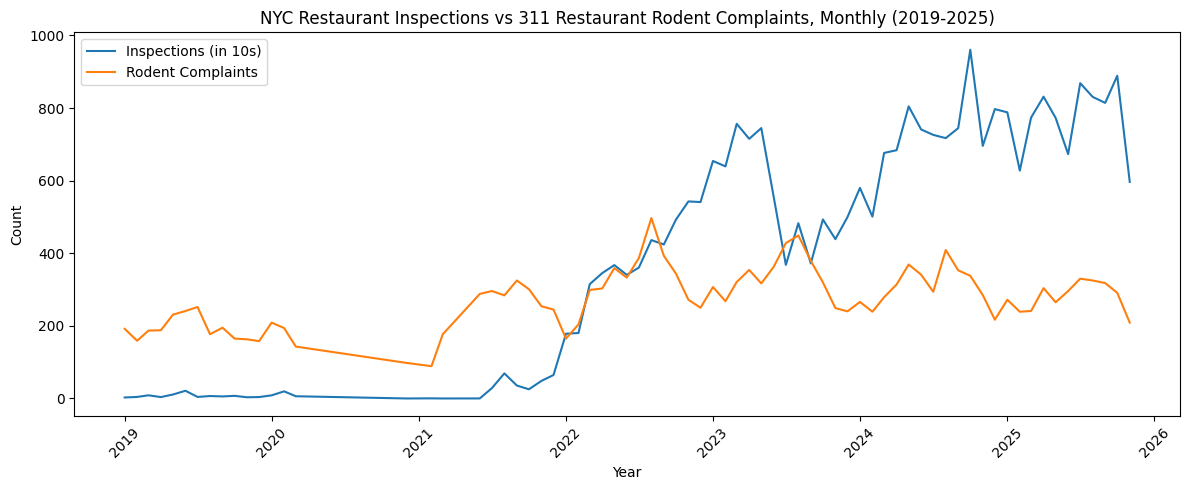

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

monthly_merged["month_ts"] = monthly_merged["month"].astype(str) + "-01"
monthly_merged["month_ts"] = pd.to_datetime(monthly_merged["month_ts"])

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(
    monthly_merged["month_ts"],
    monthly_merged["inspection_count_scaled"],
    label="Inspections (in 10s)",
)
ax.plot(
    monthly_merged["month_ts"],
    monthly_merged["complaint_count"],
    label="Rodent Complaints",
)

ax.set_title(
    "NYC Restaurant Inspections vs 311 Restaurant Rodent Complaints, Monthly (2019-2025)"
)
ax.set_ylabel("Count")
ax.set_xlabel("Year")

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=45)

ax.legend()
plt.tight_layout()
plt.show()